# Gilles Main - Do not touch !
## 1 - libraries setup
import general and custom libraries


In [1]:
# General Libraries
import numpy as np
import cv2
import opencv_jupyter_ui as jcv2
#import tdmclient.notebook
#await tdmclient.notebook.start()

#from tdmclient import ClientAsync

# Custom libraries 
from src.Vision import vision as vs              # Gilles Regamey
from src.Global_Nav import helpers_global as gn  # Julien Droulet
from src.Local_Nav import local_navigation as ln # Tom Rathjens
from src.Local_Nav import psymap as pm           # Gilles Regamey
from src.Filtering import KalmanFilter as kf     # Aubin sabatier
from src.Motion_Control import thymio as th      # ?

### Setup global variables and Constants
Map is a rectangle 1000x700 [mm]


In [2]:
MAP_SHAPE_MM = (1000,700)
MAP_SHAPE_CELL = (50,35)
CELL_SIZE =20
#testing Constants
REFRAME = True
VISUALIZE = True
#camera var
cap = cv2.VideoCapture(0)

#robot var
#client = ClientAsync()
#node = await client.wait_for_node() 
#handle = await node.lock()


## Code for the Thymio

## Code to run locally

Computing warp matrix
Finished Warp Matrix computation.
Searching for destination...
Found destination Point at [815 288] [mm] (40, 21) [cells]
Searching for Robot...
Robot found at [559 535] [mm], -2.6858188976130877 [rad]
Initial Map:
Map with optimal path


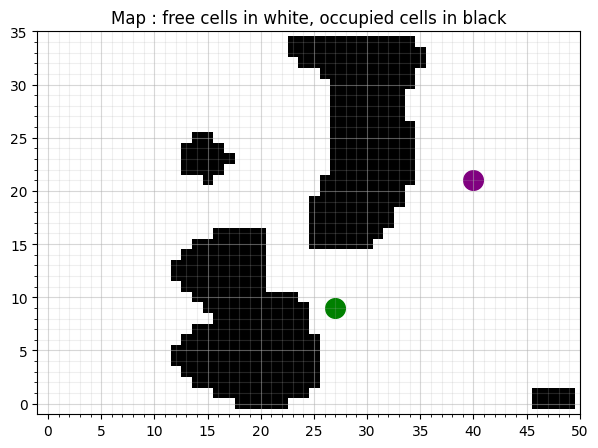

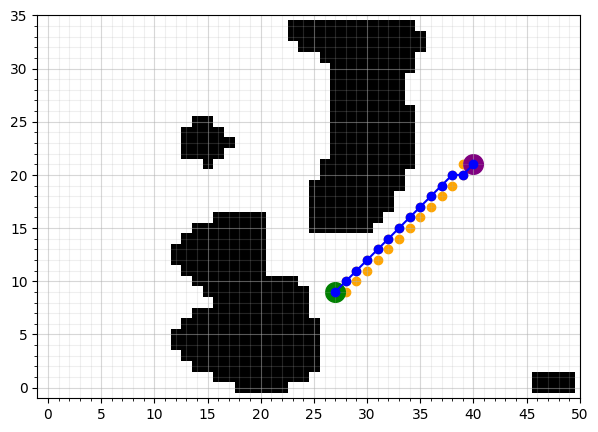

In [3]:
if REFRAME:
    Tmap = vs.get_warp(cap,MAP_SHAPE_MM,20,10)

ret,frame = cap.read()
if ret:
    if REFRAME:
        frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
    fmap = vs.get_grid_fixed_map(frame,MAP_SHAPE_CELL)
    obscont = vs.get_obstacles(frame)
    print("Searching for destination...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            ret,destmm = vs.get_destination(frame)
            if ret:
                dest = gn.convert_to_idx([coord / 10.0 for coord in destmm],2)
                dest[1]= 35-dest[1]
                dest = tuple(dest)
                break
            else:
                cv2.imshow()
        else:
            print("No camera !")
            break
    print("Found destination Point at {} [mm] {} [cells]".format(destmm,dest))
    print("Searching for Robot...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL) 
            ret,robpos,orient,pxpcm = vs.get_Robot_position_orientation(hls_frame)
            if ret:
                print("Robot found at {} [mm], {} [rad]".format(robpos,orient))
                break
        else:
            print("No camera !")
            break

start = gn.convert_to_idx(robpos,20)
start[1]= MAP_SHAPE_CELL[1]-start[1]
start = tuple(start)
path = gn.global_final(fmap,start,dest, "8N", VISUALIZE)


In [8]:
def show_path(frame,path,cell_size,robpos):
    path = np.array(path,dtype=np.int32)
    trajectory = []
    for ptcell in path:
        ptcell[1] = MAP_SHAPE_CELL[1]-ptcell[1]
        ptmm = ptcell*cell_size
        ptmm += [cell_size//2,cell_size//2]
        trajectory.append(ptmm)
    for i in range(1,len(trajectory)):
        frame = cv2.line(frame,trajectory[i-1],trajectory[i],(0,100,255),2)

    # nextpt = gn.convert_to_idx(robpos,cell_size)
    # nextpt[1]= MAP_SHAPE_CELL[1]-nextpt[1]
    # nextpt = gn.next_checkpoint(path,nextpt)
    # nextpt[1] = MAP_SHAPE_CELL[1]-nextpt[1]
    # nextmm = nextpt*cell_size
    # nextmm += [cell_size//2,cell_size//2]
    # frame = cv2.circle(frame,nextmm,10,(0,255,255),2)
    return frame

In [10]:
black = np.zeros((700,1000,3),dtype=np.uint8)
black = show_path(black,path,CELL_SIZE,robpos)

jcv2.imshow("lolo",black)
jcv2.waitKey(1)


-1

In [5]:

while True:
    ret,frame = cap.read()
    if ret:
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
        hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL) 

        gotrob,robpos,robori,pxpcm = vs.get_Robot_position_orientation(hls_frame)
        capthall = pm.hallucinate_map([robpos[0],robpos[1],(-robori)],obscont)

        if VISUALIZE:
            vizu = vs.visualizer(hls_frame)
            #omap =vs.grid_fixedmap_visualizer(fmap.transpose(),MAP_SHAPE_MM)
            #obsimg = cv2.merge([omap,omap,omap])
            #vizu = cv2.bitwise_or(vizu,obsimg)
            vizu = vs.draw_obstacles_poly(vizu,obscont,(255,255,0),2)
            vizu = cv2.circle(vizu,destmm,20,(50,25,100),4)
            vizu = cv2.addWeighted(vizu,0.5,frame,0.5,0)
            vizu = show_path(vizu,path,20,robpos)
            if gotrob:
                vizu = vs.paint_robot(vizu,(0,0,200),robpos,robori,pxpcm)
                vizu = pm.hallucinate_map([robpos[0],robpos[1],(-robori)],obscont,vizu)
            jcv2.imshow("Map",vizu)
            if jcv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("pos: {},{:.2f} dest: {} fhal: {}".format(robpos,robori,destmm,capthall),end='\r')
        

    else:
        print("camera failure.")
        break

TypeError: next_checkpoint() missing 1 required positional argument: 'position_idx'

## closing calls


In [ ]:

#To unlock the Robot
#await tdmclient.notebook.stop()
#await node.unlock()
jcv2.destroyAllWindows()